# RNN 삼성 주식가 예측


In [50]:
!pip install --q ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.55 s (started: 2024-07-02 02:12:10 +00:00)


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

time: 912 µs (started: 2024-07-02 02:12:18 +00:00)


## 1. 데이터 준비

In [52]:
samsung = pd.read_csv('/content/005930.KS.csv')
samsung.shape

(6140, 7)

time: 19.5 ms (started: 2024-07-02 02:12:18 +00:00)


In [53]:
df = samsung.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.710938,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.857910,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.101563,46880000


time: 38.2 ms (started: 2024-07-02 02:12:18 +00:00)


In [54]:
df.columns = [col.replace(' ', '_').lower() for col in df.columns]
df.head()

,date,open,high,low,close,adj_close,volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.710938,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.857910,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.101563,46880000


time: 34.3 ms (started: 2024-07-02 02:12:18 +00:00)


In [55]:
# 시계열 할 때는, datetime으로 변경하면 더 하기 쉬움
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6140 entries, 0 to 6139
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6140 non-null   object 
 1   open       6140 non-null   float64
 2   high       6140 non-null   float64
 3   low        6140 non-null   float64
 4   close      6140 non-null   float64
 5   adj_close  6140 non-null   float64
 6   volume     6140 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 335.9+ KB
time: 12.9 ms (started: 2024-07-02 02:12:18 +00:00)


In [56]:
# volume이 0 인 것이 이상함 - 거래량
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,6140.0,2.848076e+04,2.269316e+04,2540.000000,1.072000e+04,2.125000e+04,4.575000e+04,90300.0
high,6140.0,2.875581e+04,2.286959e+04,2760.000000,1.090000e+04,2.149000e+04,4.618500e+04,96800.0
low,6140.0,2.819435e+04,2.249832e+04,2420.000000,1.057500e+04,2.100000e+04,4.525000e+04,89500.0
close,6140.0,2.847089e+04,2.267169e+04,2730.000000,1.074000e+04,2.126000e+04,4.570000e+04,91000.0
adj_close,6140.0,2.462311e+04,2.216919e+04,1988.168579,7.915906e+03,1.644601e+04,3.910023e+04,85300.0
volume,6140.0,2.116503e+07,1.504670e+07,0.000000,1.169729e+07,1.715452e+07,2.617382e+07,164215000.0


time: 40.3 ms (started: 2024-07-02 02:12:18 +00:00)


In [57]:
df['volume'].value_counts()

volume
0           127
25990000      3
21495000      3
25245000      3
33430000      3
           ... 
53205000      1
27650         1
29978550      1
41059050      1
4792936       1
Name: count, Length: 5897, dtype: int64

time: 5.09 ms (started: 2024-07-02 02:12:18 +00:00)


In [58]:
df[df['volume'] == 0]

,date,open,high,low,close,adj_close,volume
23,2000-02-04,5130.0,5130.0,5130.0,5130.0,3736.008545,0
41,2000-03-01,5120.0,5120.0,5120.0,5120.0,3728.725098,0
66,2000-04-05,6800.0,6800.0,6800.0,6800.0,4952.213867,0
72,2000-04-13,6910.0,6910.0,6910.0,6910.0,5032.323730,0
84,2000-05-01,6000.0,6000.0,6000.0,6000.0,4369.602051,0
...,...,...,...,...,...,...,...
5564,2022-02-28,71900.0,71900.0,71900.0,71900.0,68423.648438,0
5567,2022-03-04,72900.0,72900.0,72900.0,72900.0,69375.296875,0
5570,2022-03-10,69500.0,69500.0,69500.0,69500.0,66139.687500,0
5573,2022-03-15,70200.0,70200.0,70200.0,70200.0,66805.835938,0


time: 16.2 ms (started: 2024-07-02 02:12:18 +00:00)


## 2. 데이터 처리

In [59]:
# volume이 0인 값 nan값으로 대체
df.loc[df['volume'] == 0, 'volume'] = np.nan
df.isna().sum()

date           0
open           0
high           0
low            0
close          0
adj_close      0
volume       127
dtype: int64

time: 12 ms (started: 2024-07-02 02:12:18 +00:00)


In [60]:
df = df.dropna()
df.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

time: 10.5 ms (started: 2024-07-02 02:12:18 +00:00)


In [61]:
# datetime으로 바꾸기
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6013 entries, 0 to 6139
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       6013 non-null   datetime64[ns]
 1   open       6013 non-null   float64       
 2   high       6013 non-null   float64       
 3   low        6013 non-null   float64       
 4   close      6013 non-null   float64       
 5   adj_close  6013 non-null   float64       
 6   volume     6013 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 375.8 KB
time: 16.3 ms (started: 2024-07-02 02:12:18 +00:00)


<ipython-input-61-3447ffe36f79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [62]:
df.head() # index를 없애고 date를 index로 쓰기

,date,open,high,low,close,adj_close,volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.710938,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.857910,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.101563,46880000.0


time: 30.9 ms (started: 2024-07-02 02:12:18 +00:00)


In [63]:
df = df.set_index('date')
df.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.710938,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.857910,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.101563,46880000.0


time: 35.5 ms (started: 2024-07-02 02:12:19 +00:00)


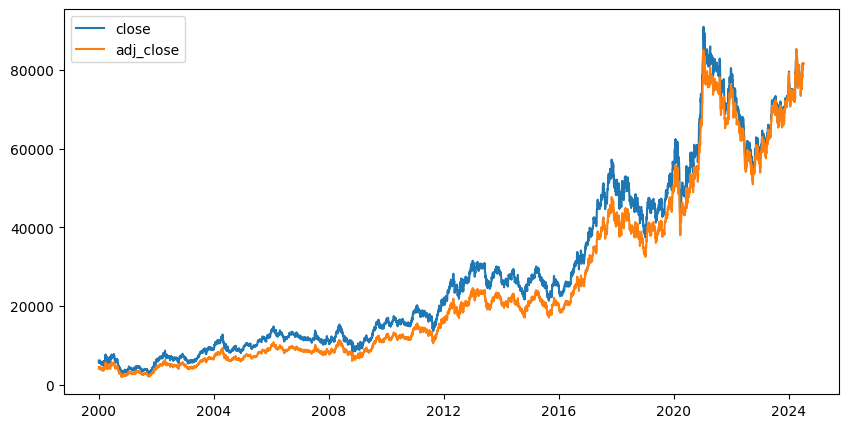

time: 767 ms (started: 2024-07-02 02:12:19 +00:00)


In [64]:
# 주식의 추이선 그려보기
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label='close') # date 사용, 종가
plt.plot(df.index, df['adj_close'], label='adj_close') # 수정 종가
plt.legend()
plt.show()

In [65]:
# 새로 컬럼을 그리기
# 3일 이동평균, 5일 이동평균이 어떻게 변하는지 등 데이터를 추가
# 3개씩 묶어서 평균내기, 소수점으로 나오므로 반올림 진행
df['ma3'] = np.around(df['close'].rolling(window=3).mean(), 0)
df['ma5'] = np.around(df['close'].rolling(window=5).mean(), 0)
df.head()

,open,high,low,close,adj_close,volume,ma3,ma5
date,,,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.710938,74195000.0,NaN,NaN
2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000.0,NaN,NaN
2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.857910,54390000.0,5770.0,NaN
2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000.0,5580.0,NaN
2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.101563,46880000.0,5643.0,5724.0


time: 103 ms (started: 2024-07-02 02:12:19 +00:00)


In [66]:
# 평균
df['mid'] = (df['low']+df['high'])/2
df.head()

,open,high,low,close,adj_close,volume,ma3,ma5,mid
date,,,,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.710938,74195000.0,NaN,NaN,5885.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000.0,NaN,NaN,5790.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.857910,54390000.0,5770.0,NaN,5680.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000.0,5580.0,NaN,5515.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.101563,46880000.0,5643.0,5724.0,5675.0


time: 80 ms (started: 2024-07-02 02:12:19 +00:00)


In [67]:
df = df.dropna()
df.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
ma3          0
ma5          0
mid          0
dtype: int64

time: 11.2 ms (started: 2024-07-02 02:12:20 +00:00)


## 3. 학습, 테스트 데이터 분리

In [68]:
idx = int(df.shape[0]*0.8)
idx

4807

time: 4.15 ms (started: 2024-07-02 02:12:20 +00:00)


In [69]:
# 숫자로 끊어낼 때는 iloc 사용
train = df.iloc[:idx, :]
test = df.iloc[idx:, :]
train.shape, test.shape

((4807, 9), (1202, 9))

time: 11.4 ms (started: 2024-07-02 02:12:20 +00:00)


### X, y 분리

In [70]:
# X, y 분리
# 다 쓸 것인지, 추려서 쓸 것이지 결정
# close, adj_close는 같으므로 나머지를 x로 두고, close만 사용
X_train = train.drop(['close', 'adj_close'], axis = 1)
y_train = train[['close']]

X_train.shape, y_train.shape

((4807, 7), (4807, 1))

time: 14.8 ms (started: 2024-07-02 02:12:20 +00:00)


In [71]:
# MinMax Scaler 사용
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
X_train_s = ms.fit_transform(X_train)
X_train_s

array([[0.05567686, 0.05496713, 0.05815237, ..., 0.0527386 , 0.05340672,
        0.05655362],
       [0.05967977, 0.06099343, 0.06164888, ..., 0.05366286, 0.05214222,
        0.06131989],
       [0.05585881, 0.05441928, 0.05852043, ..., 0.05477198, 0.0526629 ,
        0.05646196],
       ...,
       [0.80531295, 0.81336742, 0.81302908, ..., 0.81169011, 0.81352276,
        0.8131989 ],
       [0.81532023, 0.8179328 , 0.82131027, ..., 0.81908424, 0.81519637,
        0.81961503],
       [0.81077147, 0.8106282 , 0.80658815, ..., 0.81662569, 0.81649807,
        0.80861595]])

time: 17.3 ms (started: 2024-07-02 02:12:20 +00:00)


In [72]:
# y_train은 series이므로 numpy로 변경
y_train = y_train.to_numpy()
y_train

array([[ 5770.],
       [ 5770.],
       [ 5720.],
       ...,
       [47200.],
       [47300.],
       [46400.]])

time: 4.06 ms (started: 2024-07-02 02:12:20 +00:00)


### 타임스텝 데이터 형태로 변형
* RNN에 step이라는 데이터를 만들어야 함 - 얼만큼의 step을 가질지
* timestep dataset

In [73]:
def make_sequence_dataset(X, y, window_size):
    feature_list = [] # 데이터
    label_list = [] # 결과값

    for i in range(len(X) - window_size):
        feature_list.append(X[i:i+window_size]) # 20개씩 끊어서 feature에 집어 넣음
        label_list.append(y[i+window_size]) # 21번째 값을 label에 집어 넣기
    # 최종적으로 사용하고 싶을 때는 np.array로 변환
    return np.array(feature_list), np.array(label_list)

time: 969 µs (started: 2024-07-02 02:12:20 +00:00)


In [74]:
X_train_w, y_train_w = make_sequence_dataset(X_train, y_train, 20) # 20일까지 넣고, 21일 째 주가를 예측함

X_train_w.shape, y_train_w.shape

((4787, 20, 7), (4787, 1))

time: 3.78 s (started: 2024-07-02 02:12:20 +00:00)


## 4. 모델

In [98]:
from keras import layers
# 최종적으로 구하고자 하는 것은 주식 값 하나임
# LSTM에서 나온 결과값을 LSTm에 집어넣을 수있지만, 값이 폭증함
# return sequences = False - output hidden 값을 하나만 쓰겠다는 것, True면 다쓰겠다는 것
# LSTM을 두겹으로 쌓으려면 이게 중요함
model = keras.Sequential()
model.add(layers.LSTM(32, activation = 'relu', input_shape=(20, 7)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1)) # 최종적으로 activation이 Nan, linear이어서 들어오는 값이 그대로 나감

time: 172 ms (started: 2024-07-02 02:16:29 +00:00)


In [99]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                5120      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5665 (22.13 KB)
Trainable params: 5665 (22.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 32.5 ms (started: 2024-07-02 02:16:30 +00:00)


In [100]:
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # 회귀임

time: 39.7 ms (started: 2024-07-02 02:16:32 +00:00)


In [101]:
# 모델 학습
EPOCHS = 20
BATCH_SIZE = 16
history = model.fit(X_train_w, y_train_w, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/20
240/240 [==============================] - 5s 12ms/step - loss: 10339214163968.0000 - mse: 10339214163968.0000 - val_loss: 4610926313472.0000 - val_mse: 4610926313472.0000
Epoch 2/20
240/240 [==============================] - 3s 11ms/step - loss: 2322032640.0000 - mse: 2322032640.0000 - val_loss: 4558084374528.0000 - val_mse: 4558084374528.0000
Epoch 3/20
240/240 [==============================] - 3s 11ms/step - loss: 1810722176.0000 - mse: 1810722176.0000 - val_loss: 4558293041152.0000 - val_mse: 4558293041152.0000
Epoch 4/20
240/240 [==============================] - 4s 15ms/step - loss: 1376563200.0000 - mse: 1376563200.0000 - val_loss: 4557563756544.0000 - val_mse: 4557563756544.0000
Epoch 5/20
240/240 [==============================] - 3s 11ms/step - loss: 1001073984.0000 - mse: 1001073984.0000 - val_loss: 4556123013120.0000 - val_mse: 4556123013120.0000
Epoch 6/20
240/240 [==============================] - 3s 11ms/step - loss: 750173056.0000 - mse: 750173056.0000 - val

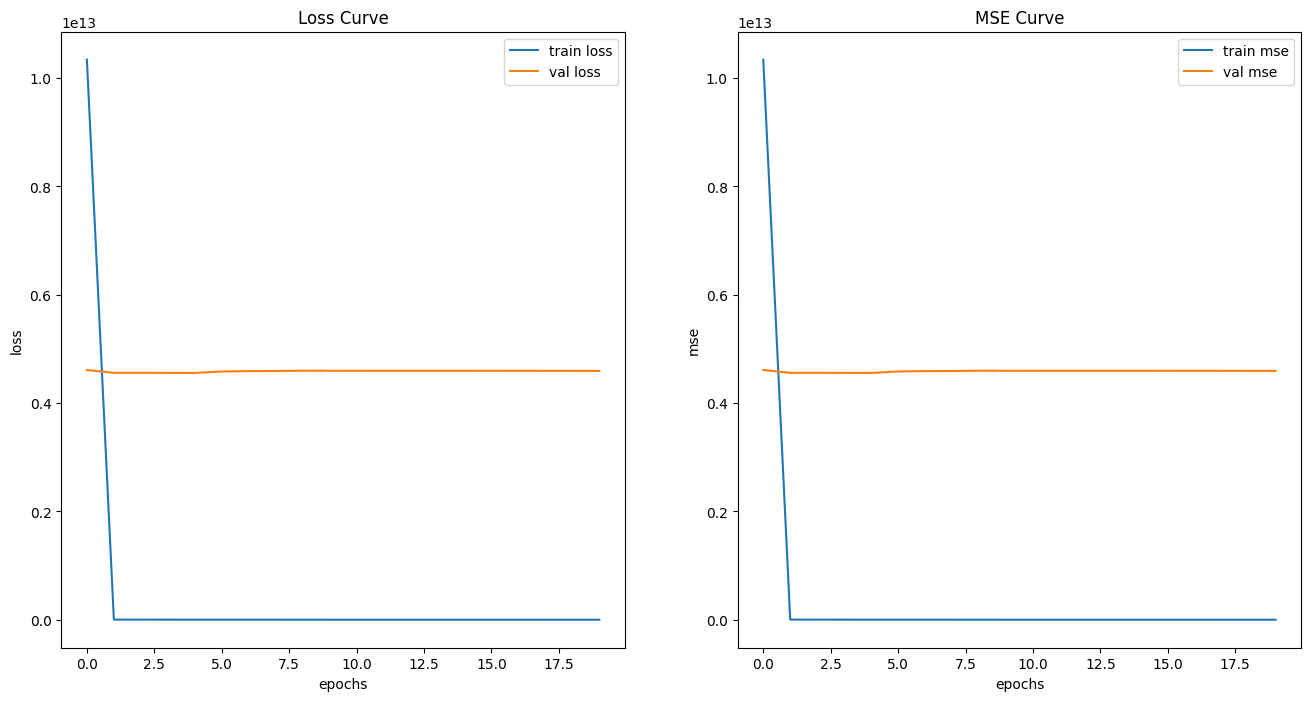

time: 951 ms (started: 2024-07-02 02:17:59 +00:00)


In [102]:
# 학습 곡선 그리기
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.plot(hist['epoch'], hist['mse'], label='train mse')
    plt.plot(hist['epoch'], hist['val_mse'], label='val mse')
    plt.title('MSE Curve')
    plt.legend()
    plt.show()

plot_history(history)

## 5. 평가

In [103]:
X_test = test.drop(['close', 'adj_close'], axis = 1)
y_test = test[['close']]

X_test.shape, y_test.shape

((1202, 7), (1202, 1))

time: 25.7 ms (started: 2024-07-02 02:18:00 +00:00)


In [104]:
X_test_s = ms.transform(X_test)
y_test = y_test.to_numpy()

X_test_s.shape, y_test.shape

((1202, 7), (1202, 1))

time: 19.5 ms (started: 2024-07-02 02:18:00 +00:00)


In [105]:
X_test_w, y_test_w = make_sequence_dataset(X_test_s, y_test, 20)
X_test_w.shape, y_test_w.shape

((1182, 20, 7), (1182, 1))

time: 17 ms (started: 2024-07-02 02:18:00 +00:00)


In [106]:
y_pred = model.predict(X_test_w)
y_pred

37/37 [==============================] - 1s 8ms/step


array([[-0.22646566],
       [-0.22703128],
       [-0.22760385],
       ...,
       [-0.25463995],
       [-0.25659955],
       [-0.2581932 ]], dtype=float32)

time: 1.59 s (started: 2024-07-02 02:18:00 +00:00)


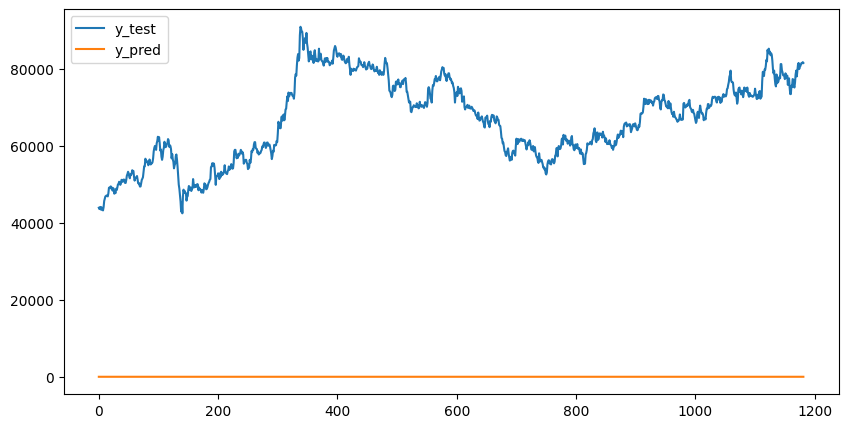

time: 296 ms (started: 2024-07-02 02:18:01 +00:00)


In [107]:
# 그래프 그려보기
plt.figure(figsize=(10, 5))
plt.plot(y_test_w, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

## 입력이 2개인 모델
* function api를 써서 여러 입력과 여러 출력을 만들 수 있음

In [112]:
# 첫번째 입력
# function

input1 = layers.Input(shape=(20, 7))
x = layers.LSTM(64, activation='relu')(input1)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output1 = layers.Dense(32, activation='relu')(x)

time: 211 ms (started: 2024-07-02 02:24:11 +00:00)


In [113]:
# 두번째 입력
input2 = layers.Input(shape=(20, 7))
x = layers.LSTM(64, activation='relu')(input2)
output2 = layers.Dense(32, activation='relu')(x)

time: 135 ms (started: 2024-07-02 02:24:12 +00:00)


In [114]:
# output을 받아서 합치기
merge = layers.Concatenate()([output1, output2])
output3 = layers.Dense(1)(merge)

model = keras.Model(inputs=[input1, input2], outputs=output3)

time: 29 ms (started: 2024-07-02 02:24:13 +00:00)


In [115]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20, 7)]              0         []                            
                                                                                                  
 lstm_9 (LSTM)               (None, 64)                   18432     ['input_4[0][0]']             
                                                                                                  
 dense_16 (Dense)            (None, 32)                   2080      ['lstm_9[0][0]']              
                                                                                                  
 input_5 (InputLayer)        [(None, 20, 7)]              0         []                            
                                                                                              

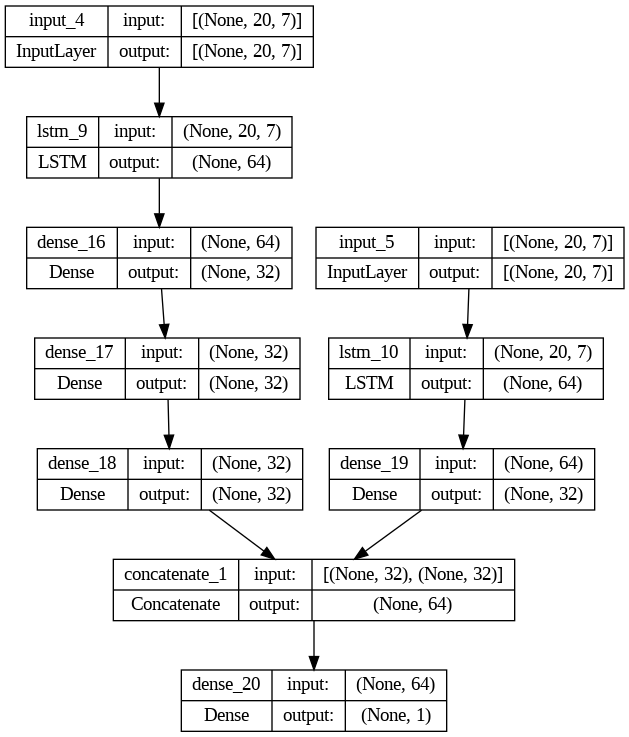

time: 702 ms (started: 2024-07-02 02:25:16 +00:00)


In [116]:
keras.utils.plot_model(model, show_shapes=True)

In [117]:
# 입력, 출력이 여러개일 때는 function api를 사용!
# 입력이 2개이면 어떻게 학습??
# 학습을 시키려면 compile을 진행
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

time: 24.1 ms (started: 2024-07-02 02:27:22 +00:00)


In [121]:
EPOCHS = 20
BATCH_SIZE = 16
# 입력이 2개이므로 2종류를 차례대로 집어넣어야 함 - list로 넣기
# 출력은 하나로 뽑음
history2 = model.fit([X_train_w, X_train_w], y_train_w,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_split=0.2)

Epoch 1/20
240/240 [==============================] - 6s 23ms/step - loss: 429891808.0000 - mse: 429891808.0000 - val_loss: 1906255360.0000 - val_mse: 1906255360.0000
Epoch 2/20
240/240 [==============================] - 9s 38ms/step - loss: 328109632.0000 - mse: 328109632.0000 - val_loss: 1528578688.0000 - val_mse: 1528578688.0000
Epoch 3/20
240/240 [==============================] - 4s 18ms/step - loss: 689295936.0000 - mse: 689295936.0000 - val_loss: 1020940864.0000 - val_mse: 1020940864.0000
Epoch 4/20
240/240 [==============================] - 6s 25ms/step - loss: 336366816.0000 - mse: 336366816.0000 - val_loss: 546531456.0000 - val_mse: 546531456.0000
Epoch 5/20
240/240 [==============================] - 4s 18ms/step - loss: 697136320.0000 - mse: 697136320.0000 - val_loss: 1114682880.0000 - val_mse: 1114682880.0000
Epoch 6/20
240/240 [==============================] - 4s 18ms/step - loss: 435008864.0000 - mse: 435008864.0000 - val_loss: 1511286272.0000 - val_mse: 1511286272.0000


In [122]:
# 예측하기 - 데이터를 2개 넣어야 됨
y_pred = model.predict([X_test_w, X_test_w])
y_pred

37/37 [==============================] - 0s 11ms/step


array([[2.7603204],
       [2.7602396],
       [2.7600799],
       ...,
       [2.7631707],
       [2.7630982],
       [2.7630463]], dtype=float32)

time: 590 ms (started: 2024-07-02 02:34:50 +00:00)


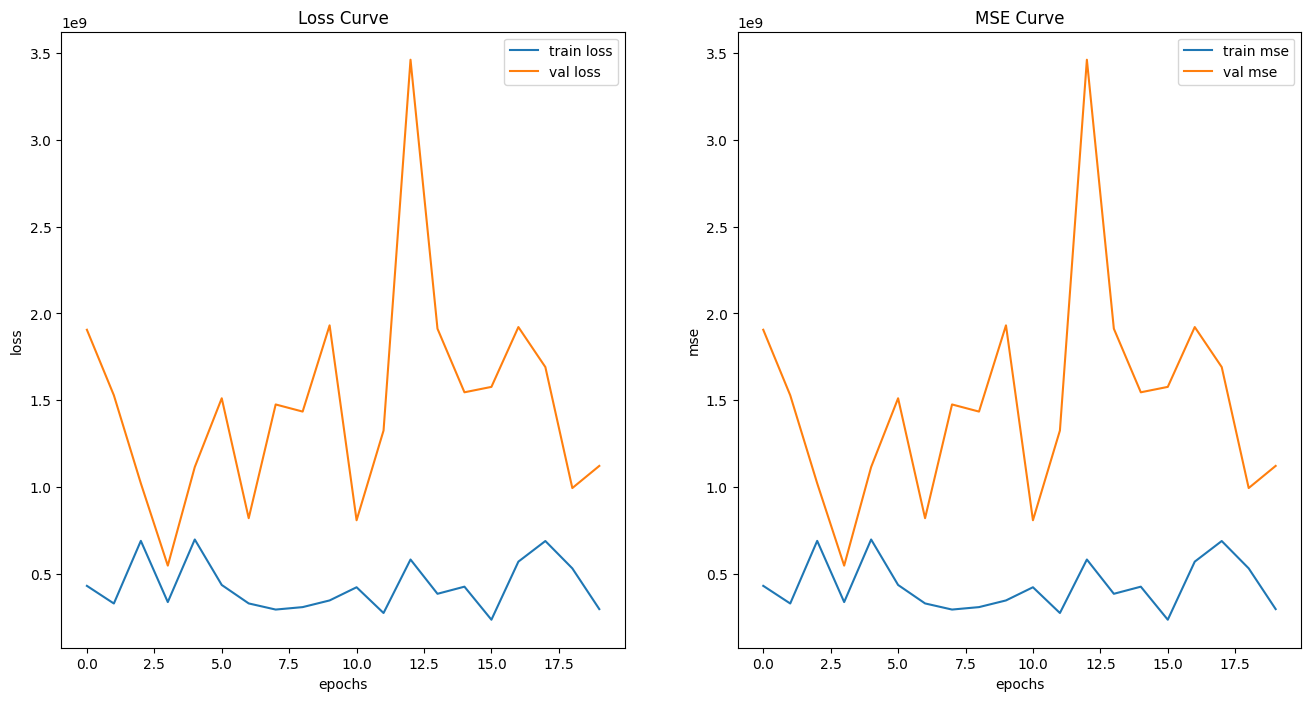

time: 896 ms (started: 2024-07-02 02:34:51 +00:00)


In [123]:
plot_history(history2)

In [ ]:
# resnet50
# 로그 분석, 시계열 데이터 - RNN을 안써도 ML쓰면 가능